<a href="https://colab.research.google.com/github/murphin8r/GAN_project/blob/main/GAN_automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset for Dad's face

In [ ]:
!pip install -Uqq fastbook
!pip install facenet-pytorch
!pip install opencv-python
import torch

from facenet_pytorch import MTCNN

from PIL import Image
import cv2

import fastbook
from fastbook import *
fastbook.setup_book()

C:\Users\murph\anaconda3\envs\gpu2\lib\site-packages\fastbook\__init__.py:19: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [ ]:
import time
import sys
from tqdm import tqdm

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
path = "C:\\Users\\murph\\OneDrive\\Family_Images"
photo_paths = get_image_files(path)
photo_paths

(#19880) [Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0263.JPG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0405.JPG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0561.PNG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0562.PNG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0563.PNG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0570.PNG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0574.JPG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0575.JPG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0576.JPG'),Path('C:/Users/murph/OneDrive/Family_Images/2016-2017 photos/IMG_0581.JPG')...]

In [ ]:
import cv2
error_count = 0
i = -1
detecter = MTCNN(image_size=64, device=device, margin=180, keep_all=True, thresholds=[0.7, 0.85, 0.90], min_face_size=60)
for p in tqdm(photo_paths):
    i += 1
    try:
        im = Image.open(p)
        if im.mode == 'RGBA' or im.mode == 'CMYK':
            detecter(np.delete(array(im),3,2), save_path='C:\\Users\\murph\\OneDrive\\Detected\\detected_face_{}.png'.format(i))
        else:
            detecter(np.asarray(im), save_path='C:\\Users\\murph\\OneDrive\\Detected\\detected_face_{}.png'.format(i))
    except:
        error_count += 1
        continue
        
print(error_count)

# GAN for Dad's Face

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as dset
import numpy as np
import torchvision.utils as vutils
import matplotlib.animation as animation
import torchvision
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
# Root directory for dataset
dataroot = "C:\\Users\\murph\\OneDrive\\Dad_Faces"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

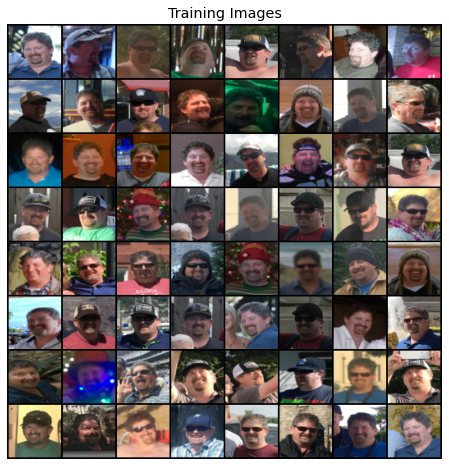

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/100][0/13]	Loss_D: 1.6999	Loss_G: 5.3912	D(x): 0.4681	D(G(z)): 0.4765 / 0.0065
[1/100][0/13]	Loss_D: 0.1369	Loss_G: 9.3548	D(x): 0.9212	D(G(z)): 0.0162 / 0.0002
[2/100][0/13]	Loss_D: 0.3692	Loss_G: 20.7793	D(x): 0.7562	D(G(z)): 0.0000 / 0.0000
[3/100][0/13]	Loss_D: 0.3258	Loss_G: 19.1232	D(x): 0.8086	D(G(z)): 0.0000 / 0.0000
[4/100][0/13]	Loss_D: 0.1118	Loss_G: 6.8892	D(x): 0.9297	D(G(z)): 0.0028 / 0.0026
[5/100][0/13]	Loss_D: 0.2847	Loss_G: 12.4310	D(x): 0.9659	D(G(z)): 0.1939 / 0.0000
[6/100][0/13]	Loss_D: 0.0758	Loss_G: 7.6252	D(x): 0.9442	D(G(z)): 0.0066 / 0.0009
[7/100][0/13]	Loss_D: 0.0904	Loss_G: 24.3111	D(x): 0.9441	D(G(z)): 0.0000 / 0.0000
[8/100][0/13]	Loss_D: 0.1866	Loss_G: 10.0872	D(x): 0.9056	D(G(z)): 0.0046 / 0.0001
[9/100][0/13]	Loss_D: 0.6718	Loss_G: 9.9503	D(x): 0.9587	D(G(z)): 0.4058 / 0.0001
[10/100][0/13]	Loss_D: 0.9979	Loss_G: 8.9663	D(x): 0.9688	D(G(z)): 0.5260 / 0.0008
[11/100][0/13]	Loss_D: 0.3658	Loss_G: 5.3430	D(x): 0.8364	D(G(z)):

[99/100][0/13]	Loss_D: 0.2686	Loss_G: 6.1991	D(x): 0.8034	D(G(z)): 0.0136 / 0.0102


** This ran for more than 100 epochs.

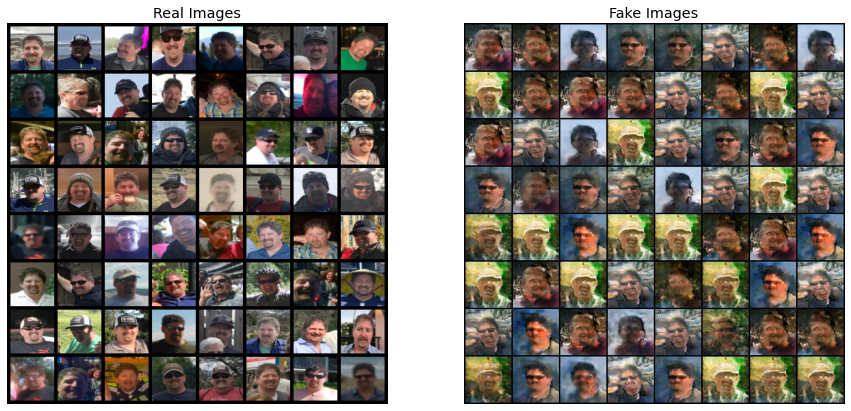

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

For my project, I automated the creation of synthetic faces using a facial-recongition software. For this code in particular, I only used my Dad's face to see if the GAN was creating was creating synthetic faces that I could recongnize. This could easily be done for camera phootage of a camera with the MTCNN to capture faces to be used. For this, I imported family photos, gathered all the faces from those photos, and scrubed the data for my Dad's face. If the purpose was to generate random faces that were not real, a random set of faces would suffice. Further automation would be needed to feed the camera data to the GAN.